(copula-estimation)=
# Bayesian copula estimation: Describing correlated joint distributions

:::{post} December 2023
:tags: copula, parameter estimation
:category: intermediate 
:author: Eric Ma, Benjamin T. Vincent
:::

## The problem
When we deal with multiple variables (e.g. $a$ and $b$) we often want to describe the joint distribution $P(a, b)$ parametrically. If we are lucky, then this joint distribution might be 'simple' in some way. For example, it could be that $a$ and $b$ are statistically independent, in which case we can break down the joint distribution into $P(a, b) = P(a) P(b)$ and so we just need to find appropriate parametric descriptions for $P(a)$ and $P(b)$. Even if this is not appropriate, it may be that $P(a, b)$ could be described well by a simple multivariate distribution, such as a multivariate normal distribution for example.

However, very often when we deal with real datasets, there is complex correlational structure in $P(a, b)$ meaning that these two previous approaches are not available to us. So alternative methods are required.

## Copulas to the rescue
This is where [copulas](https://en.wikipedia.org/wiki/Copula_(probability_theory)) come in. These allow you do describe a complex distribution $P(a, b)$ with correlational structure by a simple multivariate distribution (such as a Multivariate Gaussian), two marginal distributions, and some transformations. For a very accessible introduction to copulas, we recommend reading through [this](https://twiecki.io/blog/2018/05/03/copulas/) blog post by Thomas Wiecki.

This notebook covers how we can describe a distribution $P(a, b)$ with correlational structure using Bayesian methods to infer the parameters of the copula. The general approach we will take is shown in the schematic below.
- At the bottom, we have our **observation space** where the data lives.
- We can assume that this data was generated through the process from top to bottom - we have a multivariate normal distribution in **multivariate normal space** which is transformed in two stages to result in our data in observation space. 
- We have access to data in **observation space** but we can make inferences about the parameters in **multivariate normal space** by transforming from one to the other.

:::{figure-md} copula-fig-target

<img src="copula_schematic.png" alt="copula schematic" width="100%">

Schematic of a 2D Gaussian copula. Our complex distribution P(a, b) in observation space (bottom) is modelled as being generated by a 2D Gaussian copula in multivariate normal space (top). Mapping from multivariate normal space to observation space (downwards) is done by the normal cumulative density function and then the inverse cumulative density function of the marginal distributions. The reverse, inference, process (upwards) can be done through the cumulative density function of the marginal distributions followed by an inverse cumulative density function of the normal distribution.
:::

This notebook will describe how to make inferences about copulas based on bivariate data with rich correlational structure. We at [PyMC Labs](https://www.pymc-labs.com) completed this work as part of a larger project with the [Gates Foundation](https://www.gatesfoundation.org), some of which has also been outlined {ref}`here <binning>`.

![](gates_labs_logos.png)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from scipy.stats import expon, multivariate_normal, norm

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
plt.rcParams.update({"font.size": 14, "figure.constrained_layout.use": False})
SEED = 43
rng = np.random.default_rng(SEED)

## Data generating process
Before diving in to inference, we will spend some time fleshing out the steps in the schematic figure above. First, we will demonstrate the generative model by describing a multivariate normal copula and transform that into observation space. Second, we show how the inverse transformations can allow use to move back from observation space to multivariate normal space. Once we have these details pinned down, we proceed to the inference process in a later section.

Now we will define the properties of our Gaussian copula with a nested dictionary. At the top level we have keys `a` and `b` and `rho`. 

- `rho` describes the correlation coefficient of the multivariate normal copula. 
- `a` and `b` are also dictionaries, each of which contains the marginal distribution (as a scipy distribution object) and their parameters.

Note that we implicitly define the multivariate normal to have zero mean and unit variance. This is because these moments do not survive the transformation through 'uniform space', the second step in our copula schematic above.

In [3]:
# define properties of our copula
b_scale = 2
θ = {"a_dist": norm(), "b_dist": expon(scale=1 / b_scale), "rho": 0.9}

First, we define the true multivariate normal and draw some samples from it.

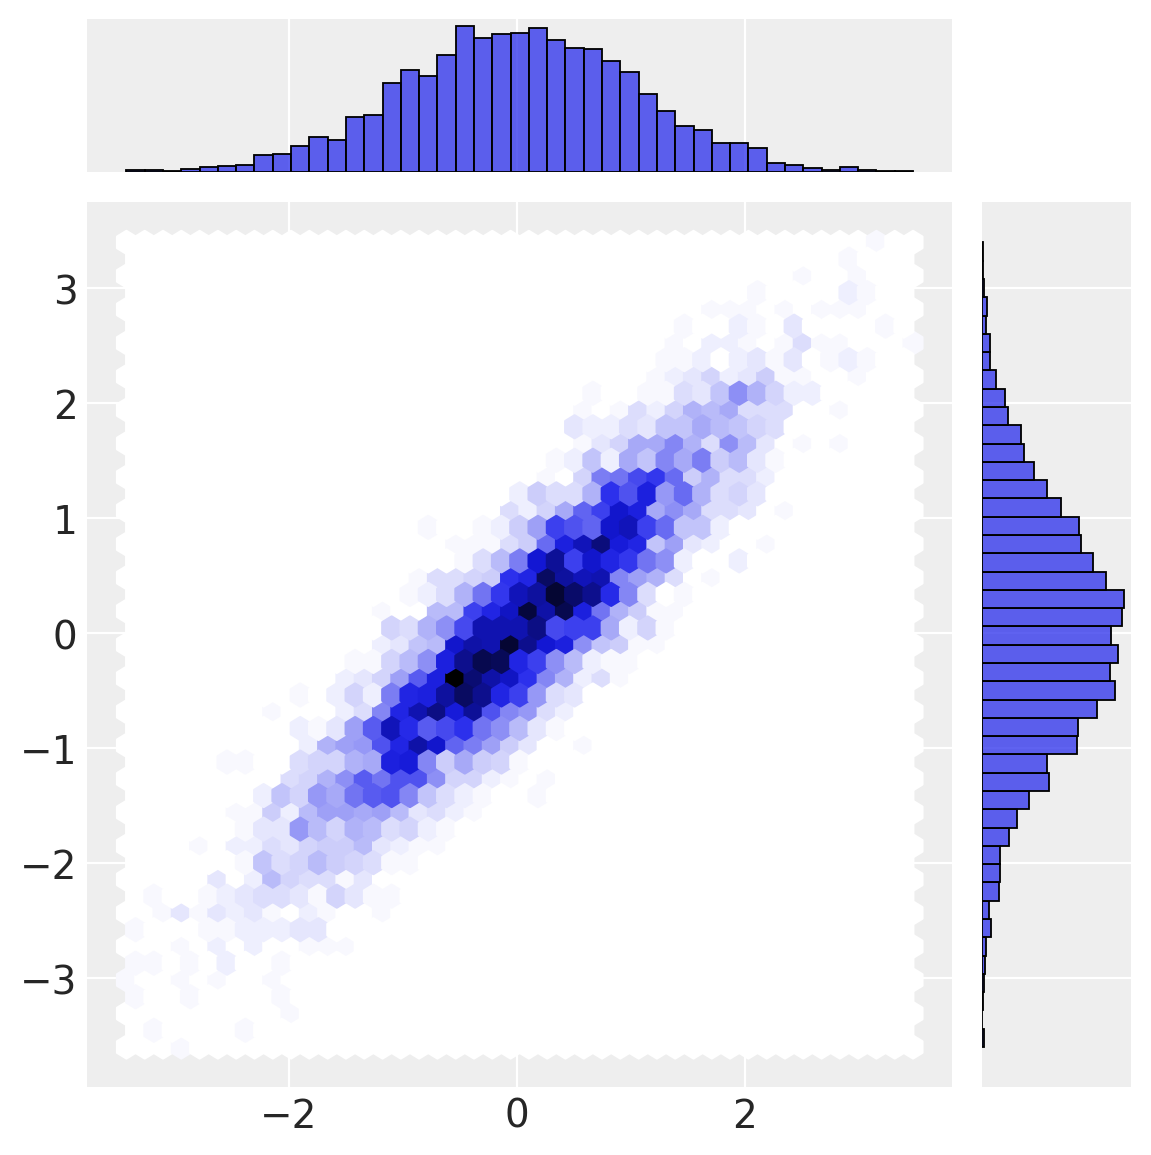

In [4]:
n_samples = 5000

# draw random samples in multivariate normal space
mu = [0, 0]
cov = [[1, θ["rho"]], [θ["rho"], 1]]
x = multivariate_normal(mu, cov).rvs(n_samples, random_state=rng)
a_norm = x[:, 0]
b_norm = x[:, 1]

sns.jointplot(x=a_norm, y=b_norm, height=6, kind="hex");

Our first transformation (normal cdf) transforms data from multivariate normal space into uniform space. Note how the marginal distributions are uniform, but the correlational structure from the multivariate normal space remains in the interesting joint density below.

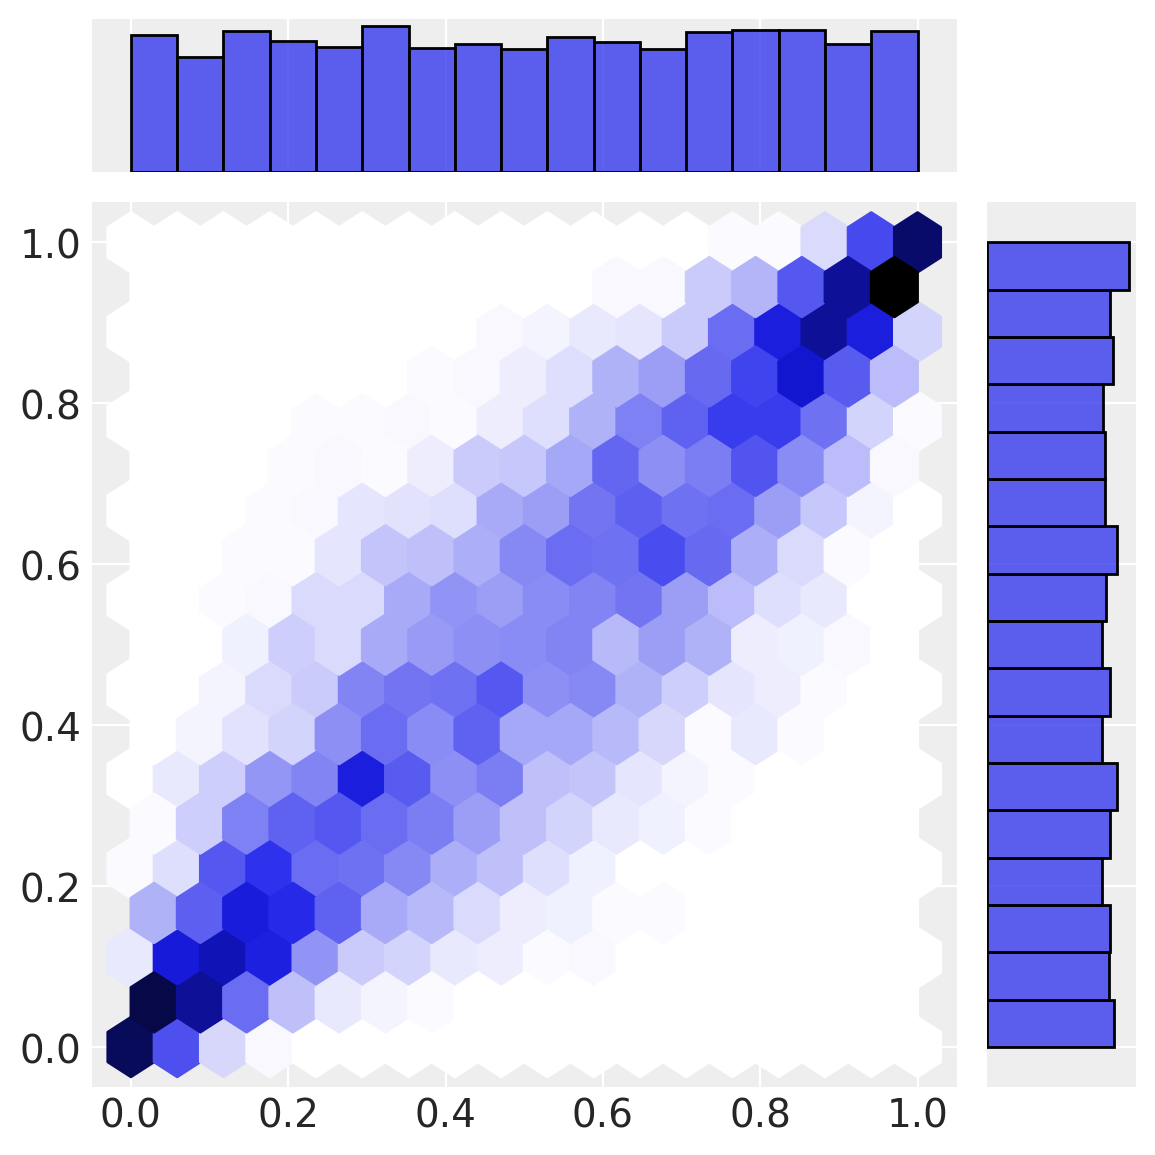

In [5]:
# make marginals uniform
a_unif = norm(loc=0, scale=1).cdf(a_norm)
b_unif = norm(loc=0, scale=1).cdf(b_norm)
sns.jointplot(x=a_unif, y=b_unif, height=6, kind="hex");

Our final transformation (the inverse CDF of the marginal distributions) gives rise to $a$ and $b$ in observation space.

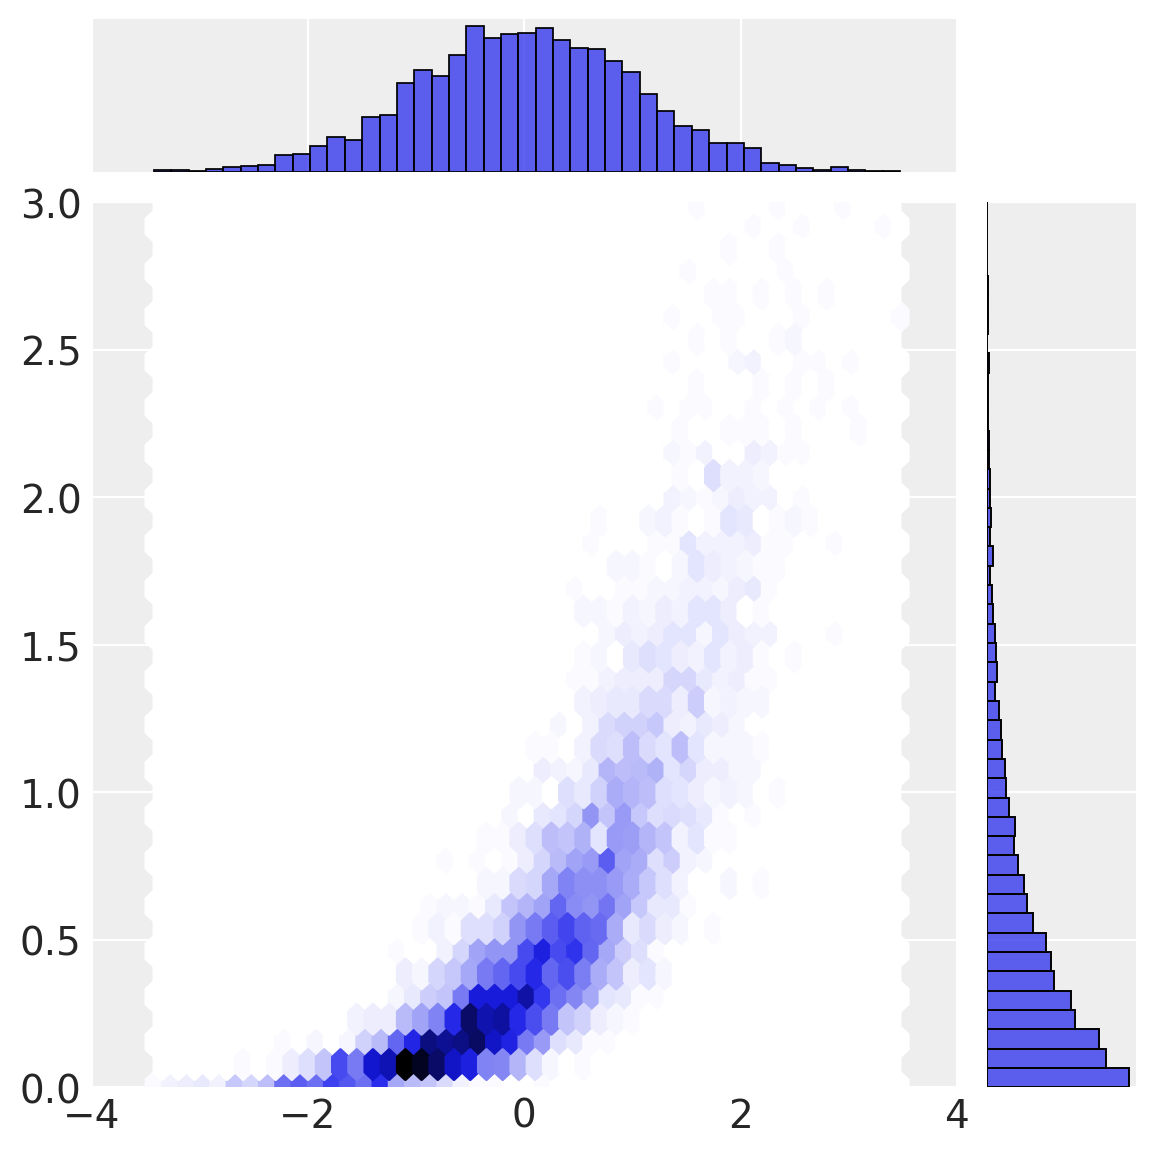

In [6]:
# transform to observation space
a = θ["a_dist"].ppf(a_unif)
b = θ["b_dist"].ppf(b_unif)
sns.jointplot(x=a, y=b, height=6, kind="hex", xlim=(-4, 4), ylim=(0, 3));

## Copula inference process
To understand the approach taken, we will walk through the inverse process, going from observation space to multivariate normal space.

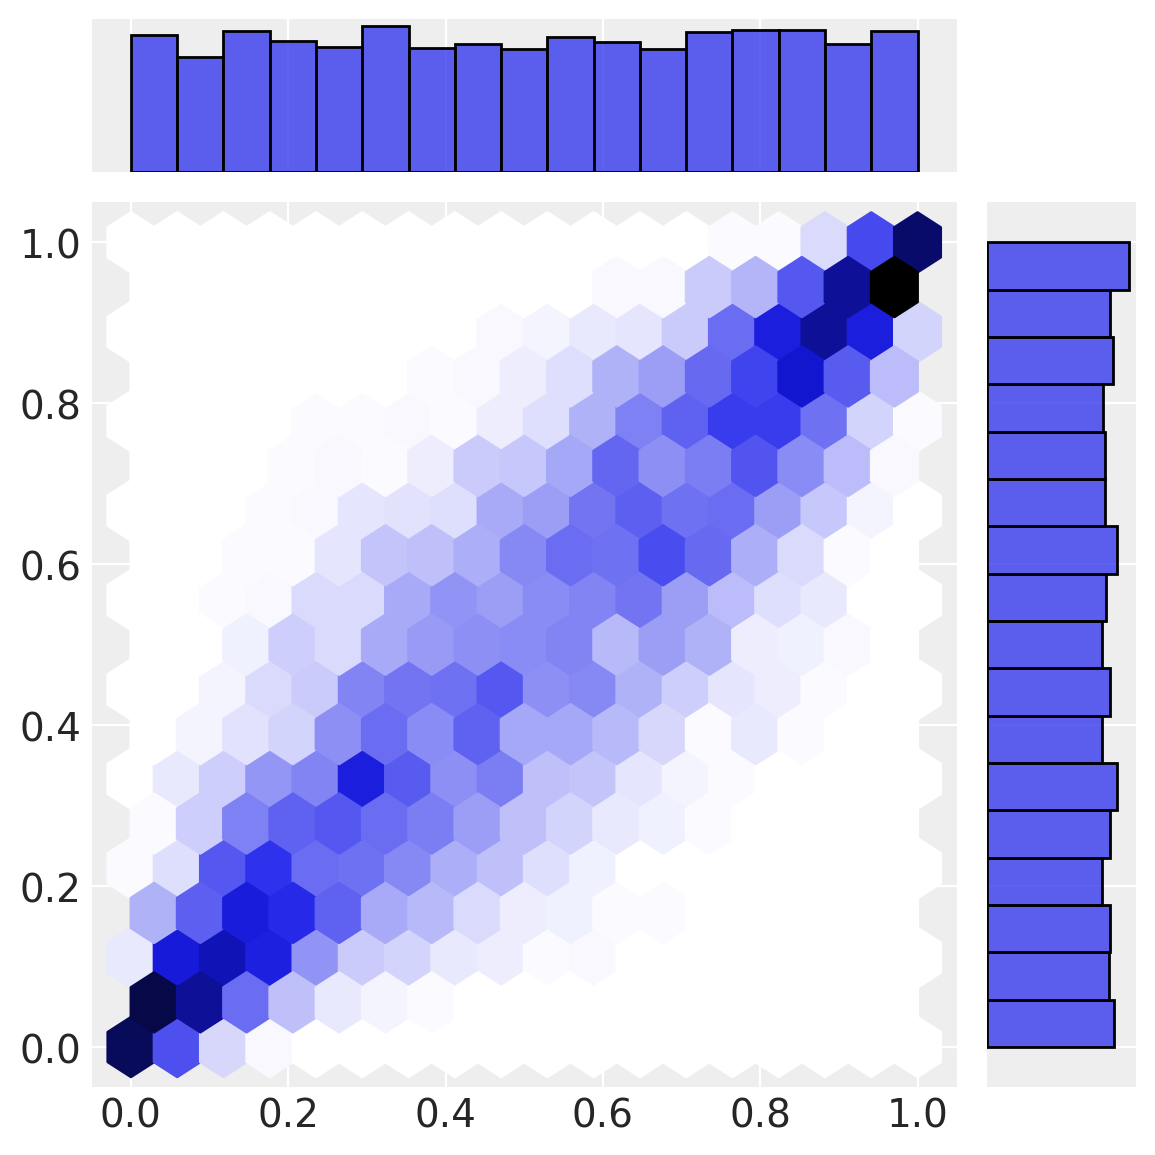

In [7]:
# observation -> uniform space
a1 = θ["a_dist"].cdf(a)
b1 = θ["b_dist"].cdf(b)
sns.jointplot(x=a1, y=b1, kind="hex", height=6);

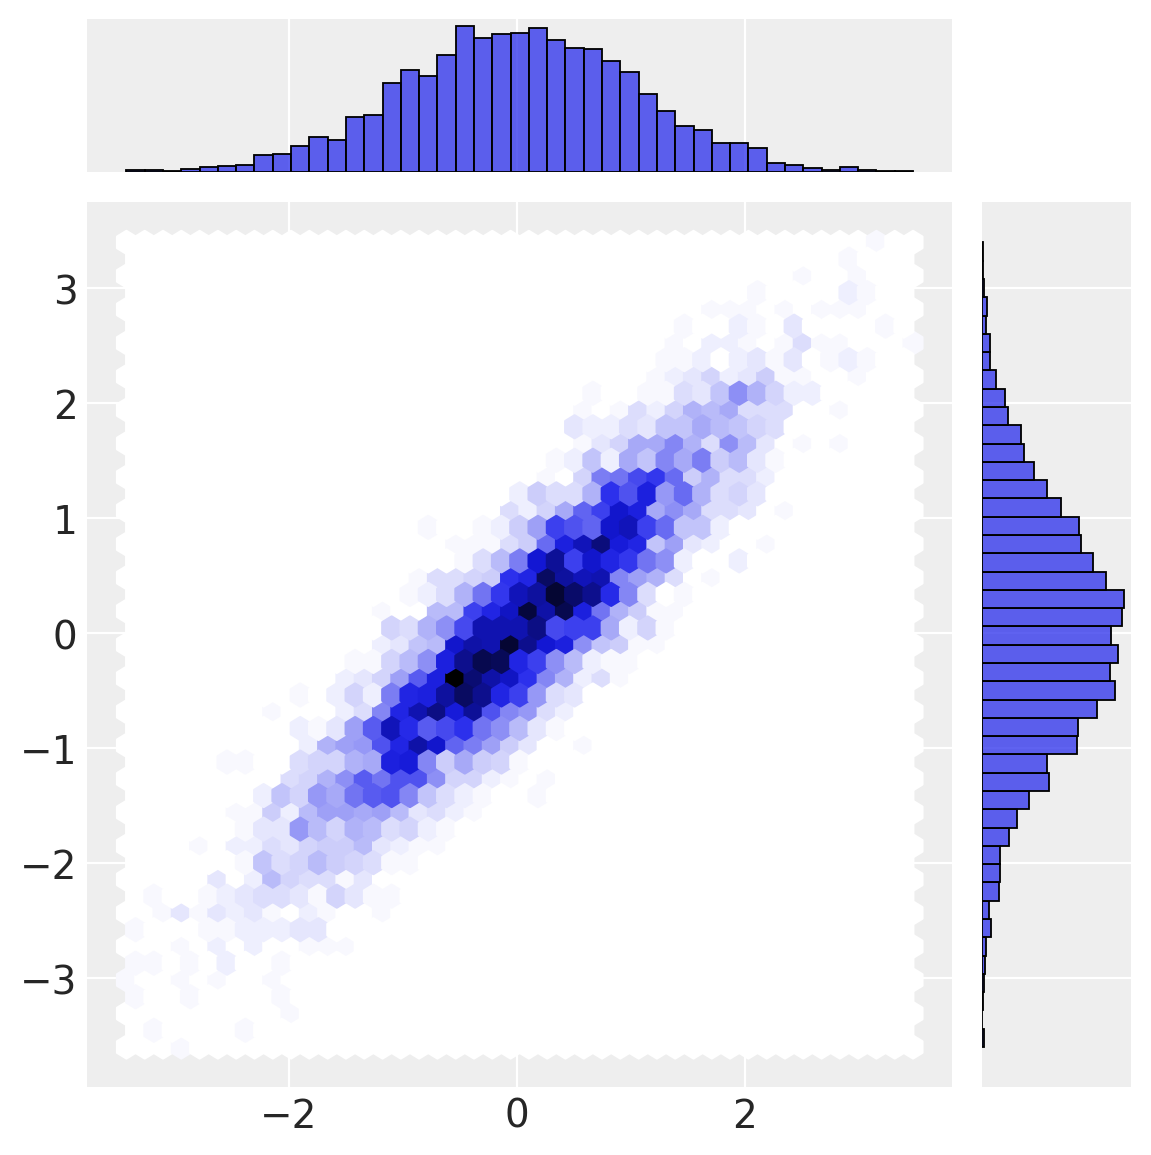

In [8]:
# uniform -> MvNormal space
a2 = norm(loc=0, scale=1).ppf(a1)
b2 = norm(loc=0, scale=1).ppf(b1)
sns.jointplot(x=a2, y=b2, kind="hex", height=6);

So now we have worked through what we outlined in Figure 1. We have stepped through in detail the data generating process going from multivariate normal to observation space. We then saw how to do the inverse (inference) process going from observation space to multivariate normal space. This is the approach we use in the PyMC model.

## PyMC models for copula and marginal estimation

We will conduct inferences about parameters in multivariate normal space, constraining plausible parameter values by the data in observation space. However, we also use our observations of $a$ and $b$ to constrain estimates of the parameters of the marginal distributions.

In our experimentation, we explored models which conducted simultaneous estimation of the parameters of the marginals, and the covariance parameter of the copula, but we found this unstable. The solution we used below was found to be more robust, and involves a 2-step process. 

1. Estimate the parameters of the marginal distributions. 
2. Estimate the covariance parameter of the copula, using point estimates of the marginal distribution parameters from step 1.

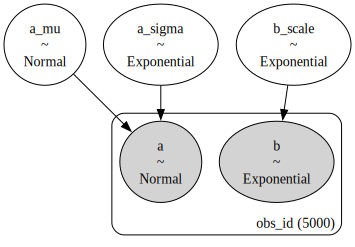

In [9]:
coords = {"obs_id": np.arange(len(a))}
with pm.Model(coords=coords) as marginal_model:
    """
    Assumes observed data in variables `a` and `b`
    """
    # marginal estimation
    a_mu = pm.Normal("a_mu", mu=0, sigma=1)
    a_sigma = pm.Exponential("a_sigma", lam=0.5)
    pm.Normal("a", mu=a_mu, sigma=a_sigma, observed=a, dims="obs_id")

    b_scale = pm.Exponential("b_scale", lam=0.5)
    pm.Exponential("b", lam=1 / b_scale, observed=b, dims="obs_id")

pm.model_graph.model_to_graphviz(marginal_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma, b_scale]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


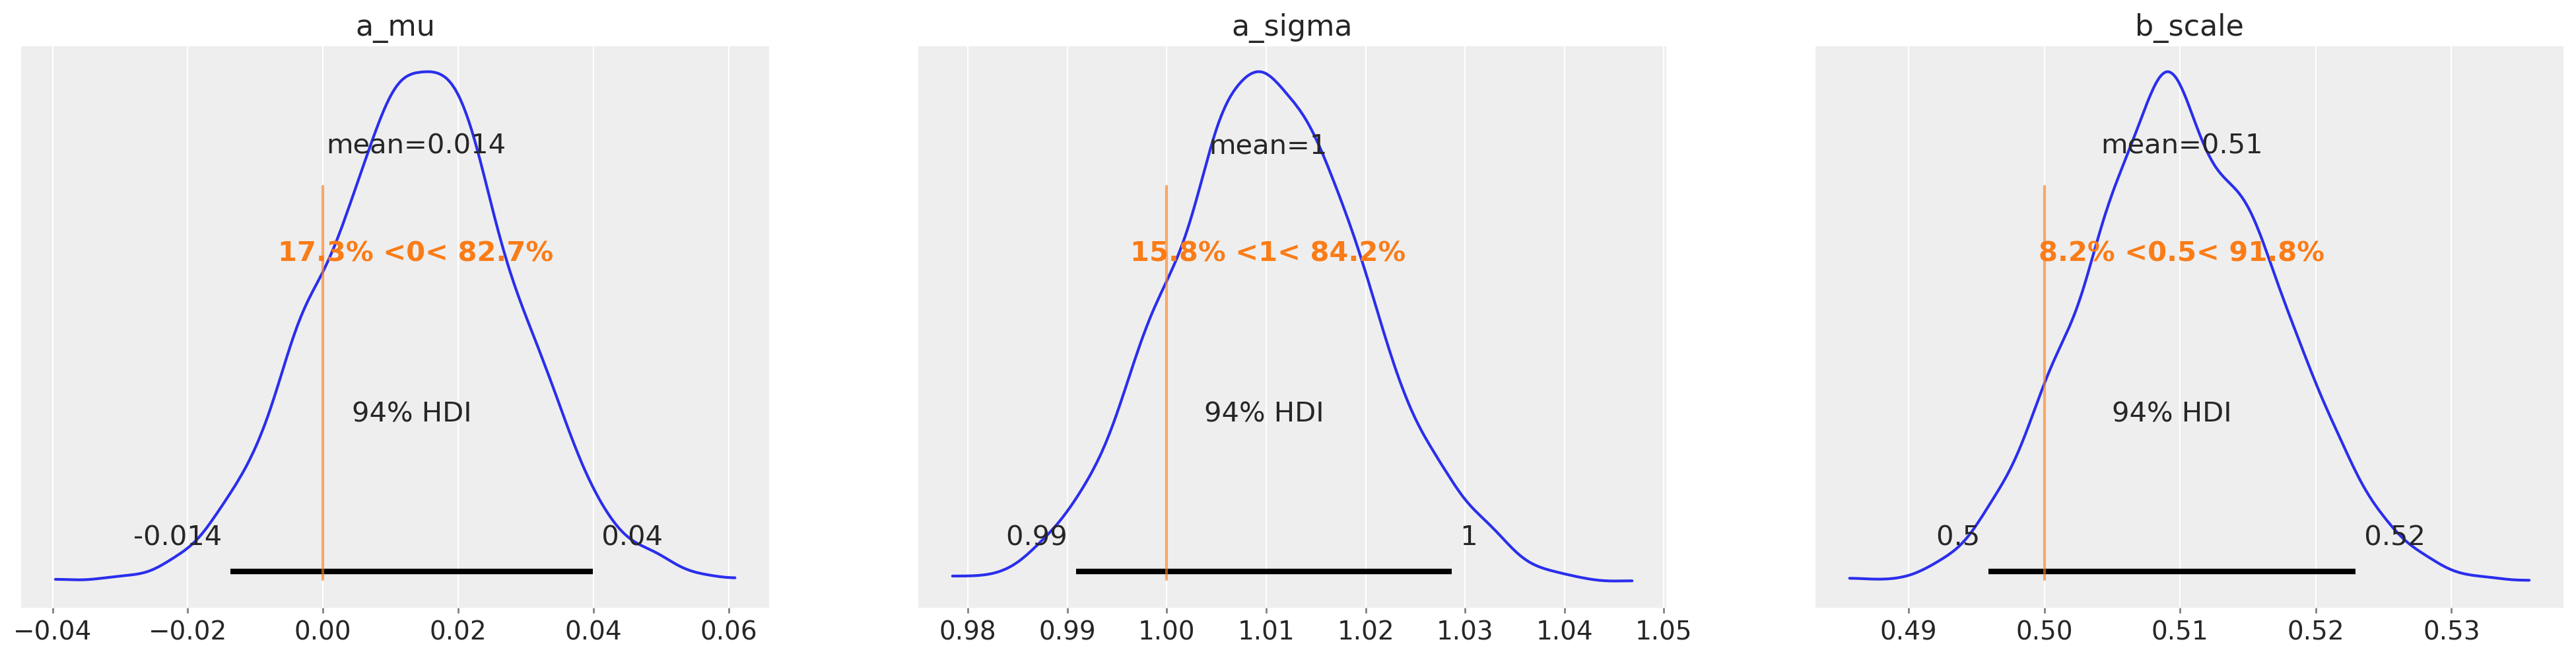

In [10]:
with marginal_model:
    marginal_idata = pm.sample(random_seed=rng)

az.plot_posterior(
    marginal_idata, var_names=["a_mu", "a_sigma", "b_scale"], ref_val=[0, 1.0, 1 / 2.0]
);

In the copula model below you can see that we set up a prior over the covariance parameter. The posterior distribution over this parameter is constrained by the data in multivariate normal space. But in order to do that we need to transform the observations `[a, b]` in observation space, to multivariate normal space, which we store in `data`.

On using point estimates: as you'll see in the code below we have opted to use point estimates from Step 1 rather than the full posterior from Step 1. This is a simplification that we opted for due to complexities in tensor shape handling when passing in posterior distributions as parameters to a distribution.

During notebook review, however, [@OriolAbril](https://github.com/OriolAbril) (one of the maintainers of the PyMC Examples repository) correctly pointed out that exponentiating the logcdf of a data point evaluated under a distribution using point estimates _will not necessarily_ return an value equal to the expectation of exponentiating the logcdf of a data point evaluated under many possible distributions (constructed from a full posterior). To ensure timely progress on the notebook, we have opted to show the code as-is, but also leave this note for both our future selves to update the notebook later while also providing an opportunity for future readers to contribute through modifying the example to address this point.

In [11]:
def transform_data(marginal_idata):
    # point estimates
    a_mu = marginal_idata.posterior["a_mu"].mean().item()
    a_sigma = marginal_idata.posterior["a_sigma"].mean().item()
    b_scale = marginal_idata.posterior["b_scale"].mean().item()
    # transformations from observation space -> uniform space
    __a = pt.exp(pm.logcdf(pm.Normal.dist(mu=a_mu, sigma=a_sigma), a))
    __b = pt.exp(pm.logcdf(pm.Exponential.dist(lam=1 / b_scale), b))
    # uniform space -> multivariate normal space
    _a = pm.math.probit(__a)
    _b = pm.math.probit(__b)
    # join into an Nx2 matrix
    data = pt.math.stack([_a, _b], axis=1).eval()
    return data, a_mu, a_sigma, b_scale


data, a_mu, a_sigma, b_scale = transform_data(marginal_idata)

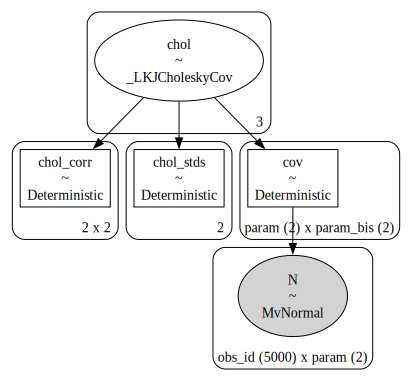

In [12]:
coords.update({"param": ["a", "b"], "param_bis": ["a", "b"]})
with pm.Model(coords=coords) as copula_model:
    # Prior on covariance of the multivariate normal
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    # Likelihood function
    pm.MvNormal("N", mu=0.0, cov=cov, observed=data, dims=("obs_id", "param"))

pm.model_graph.model_to_graphviz(copula_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [chol]


/Users/benjamv/opt/mambaforge/envs/pymc_env/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


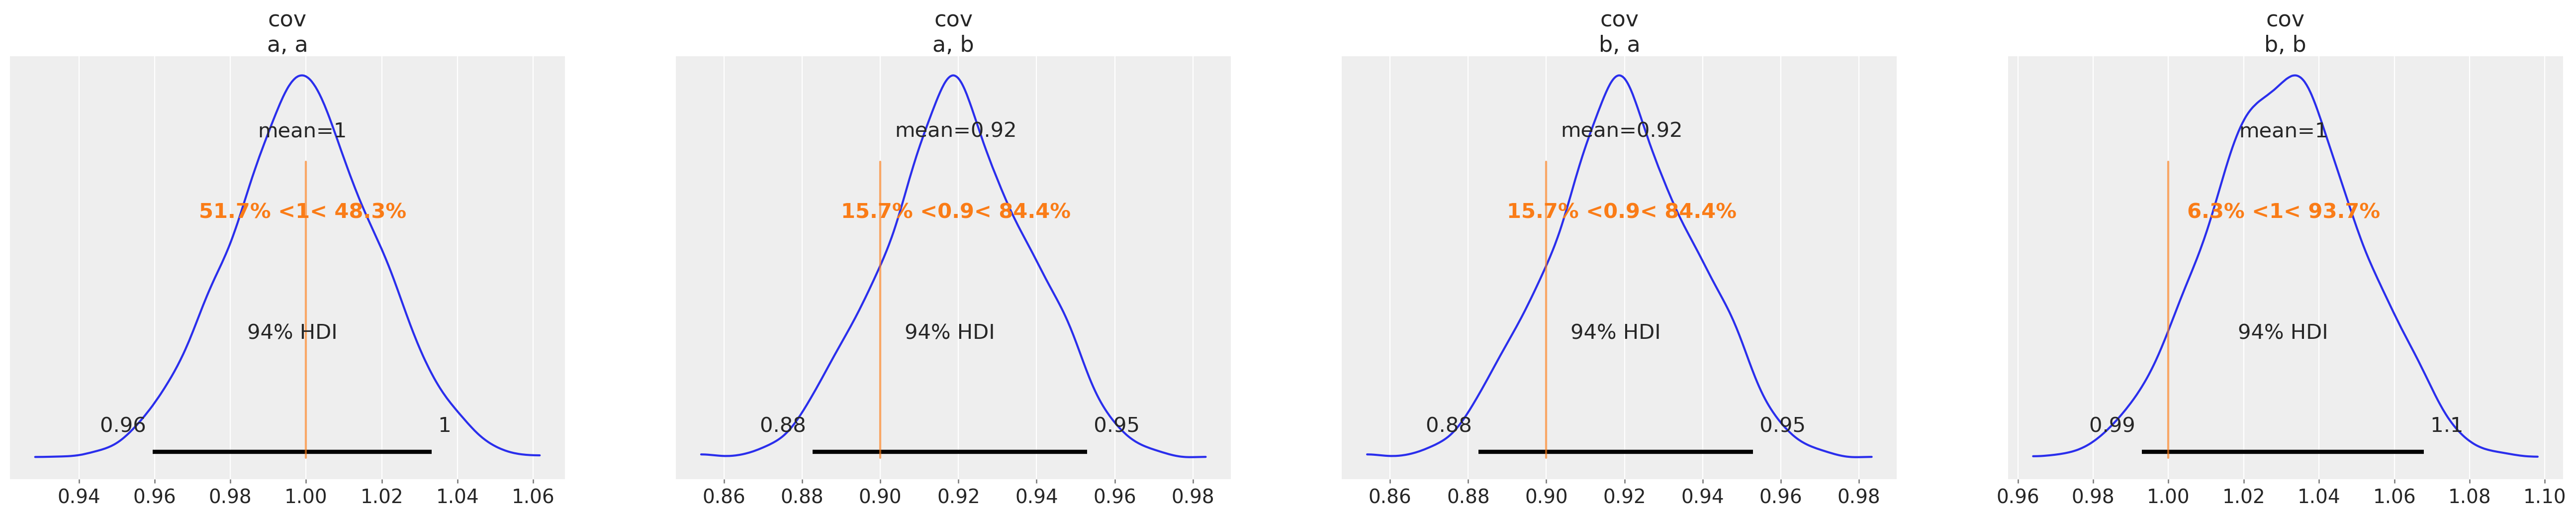

In [13]:
with copula_model:
    copula_idata = pm.sample(random_seed=rng, tune=2000, cores=1)

az.plot_posterior(copula_idata, var_names=["cov"], ref_val=[1.0, θ["rho"], θ["rho"], 1.0]);

You can see that we have successfully recovered the covariance matrix of the multivariate normal copula which was used to generate the sample data.

In the section below, we will use this information in order to sample from our parametric description of $P(a, b)$.

## Comparing inferences against the true data
Finally, we can do a visual check to see whether our inferences (red) match up with our original observed data (black).

In [14]:
# data munging to extract covariance estimates from copula_idata in useful shape
d = {k: v.values.reshape((-1, *v.shape[2:])) for k, v in copula_idata.posterior[["cov"]].items()}

# generate (a, b) samples
ab = np.vstack([multivariate_normal([0, 0], cov).rvs() for cov in d["cov"]])

# transform to uniform space
uniform_a = norm().cdf(ab[:, 0])
uniform_b = norm().cdf(ab[:, 1])

# transform to observation space
# estimated marginal parameters a_mu, a_sigma, b_scale are point estimates from marginal estimation.
ppc_a = norm(loc=a_mu, scale=a_sigma).ppf(uniform_a)
ppc_b = expon(scale=b_scale).ppf(uniform_b)

/Users/benjamv/opt/mambaforge/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:166: UserWarning: The following kwargs were not used by contour: 'linestyle'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


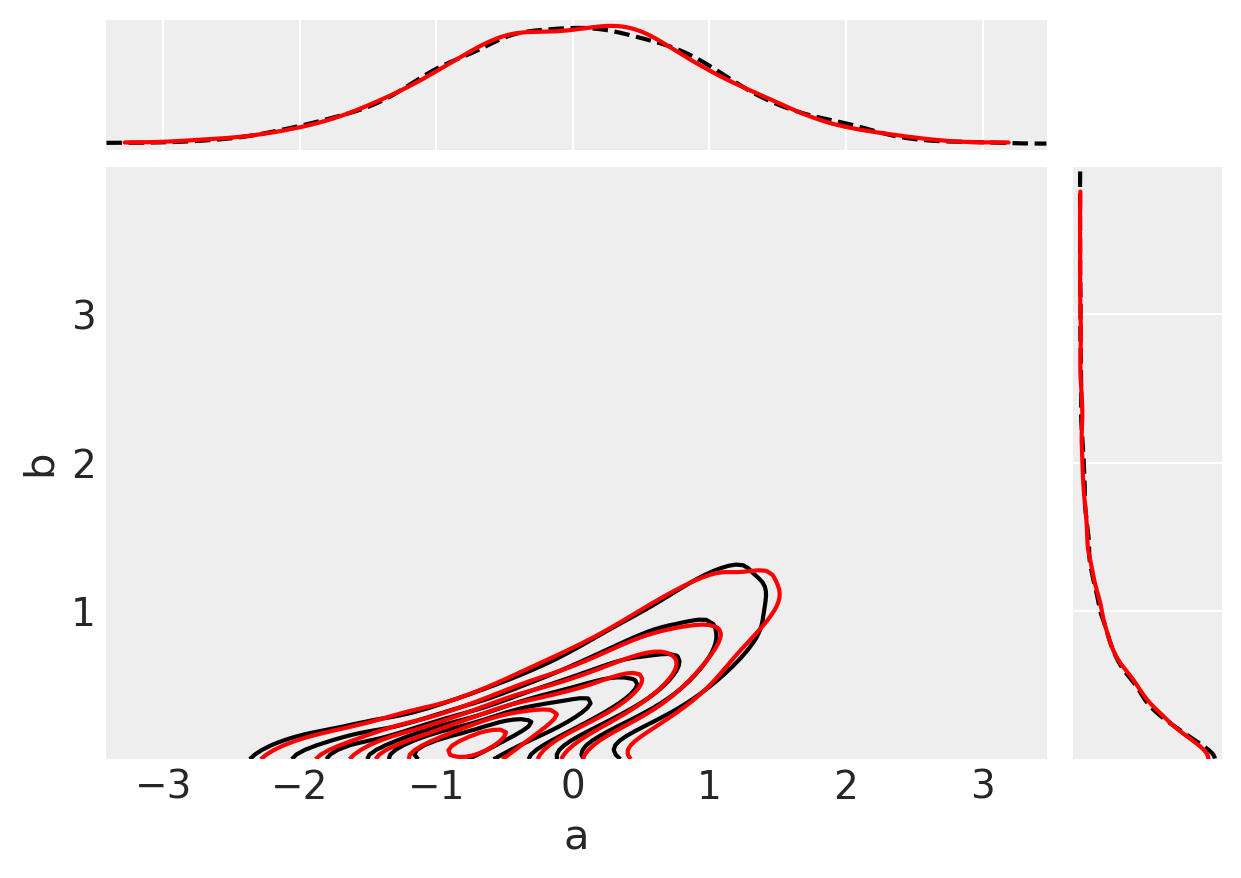

In [15]:
# plot data in black
ax = az.plot_pair(
    {"a": a, "b": b},
    marginals=True,
    # kind=["kde", "scatter"],
    kind="kde",
    scatter_kwargs={"alpha": 0.1},
    kde_kwargs=dict(
        contour_kwargs=dict(colors="k", linestyles="--"), contourf_kwargs=dict(alpha=0)
    ),
    marginal_kwargs=dict(color="k", plot_kwargs=dict(ls="--")),
)

# plot inferences in red
axs = az.plot_pair(
    {"a": ppc_a, "b": ppc_b},
    marginals=True,
    # kind=["kde", "scatter"],
    kind="kde",
    scatter_kwargs={"alpha": 0.01},
    kde_kwargs=dict(contour_kwargs=dict(colors="r", linestyles="-"), contourf_kwargs=dict(alpha=0)),
    marginal_kwargs=dict(color="r"),
    ax=ax,
);

## Acknowledgements
We would like to acknowledge [Jonathan Sedar](https://github.com/jonsedar), [Junpeng Lao](https://github.com/junpenglao), and [Oriol Abril](https://github.com/OriolAbril) for useful advice during the development of this notebook.

## Authors
* Authored by [Eric Ma](https://www.pymc-labs.com/team) & [Benjamin T. Vincent](https://github.com/drbenvincent) in November, 2023 ([pymc-examples#257](https://github.com/pymc-devs/pymc-examples/pull/257)).

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Mon Dec 04 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.1

pytensor: 2.18.1
xarray  : 2023.11.0

arviz     : 0.16.1
pymc      : 5.10.0
seaborn   : 0.13.0
matplotlib: 3.8.2
numpy     : 1.26.2
pytensor  : 2.18.1

Watermark: 2.4.3



:::{include} ../page_footer.md
:::